In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/big-mart-sales-prediction-datasets/sample_submission.csv
/kaggle/input/big-mart-sales-prediction-datasets/train.csv
/kaggle/input/big-mart-sales-prediction-datasets/test.csv


In [113]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.ensemble import  GradientBoostingRegressor,RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler

from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import seaborn as sns


sns.set_context("talk")
plt.style.use("ggplot")
plt.rcParams["figure.titlesize"] = 20
plt.rcParams["axes.titlesize"] = 18
sns.set_theme(palette="Paired")

pd.set_option("display.precision", 3)
pd.options.display.float_format = "{:,.3f}".format

%matplotlib inline
%config InlineBackend.figure_format='retina'

train_file = "/kaggle/input/big-mart-sales-prediction-datasets/train.csv"
test_file = "/kaggle/input/big-mart-sales-prediction-datasets/test.csv"

In [3]:
df = pd.concat(
          [pd.read_csv(train_file),
         pd.read_csv(test_file)],
         
).assign(id= lambda x: x.Outlet_Identifier + "-" +  x.Item_Identifier)\
.set_index('id')
target = "Item_Outlet_Sales"
df.sample(4)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
id,,,,,,,,,,,,
OUT027-FDE26,FDE26,NaN,Low Fat,0.089,Canned,145.479,OUT027,1985,Medium,Tier 3,Supermarket Type3,NaN
OUT027-FDJ50,FDJ50,NaN,Low Fat,0.021,Canned,52.098,OUT027,1985,Medium,Tier 3,Supermarket Type3,NaN
OUT019-FDO10,FDO10,NaN,Regular,0.000,Snack Foods,58.759,OUT019,1985,Small,Tier 1,Grocery Store,400.812
OUT046-NCJ31,NCJ31,19.200,Low Fat,0.183,Others,243.020,OUT046,1997,Small,Tier 1,Supermarket Type1,"3,374.274"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14204 entries, OUT049-FDA15 to OUT045-FDU37
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            14204 non-null  object 
 1   Item_Weight                11765 non-null  float64
 2   Item_Fat_Content           14204 non-null  object 
 3   Item_Visibility            14204 non-null  float64
 4   Item_Type                  14204 non-null  object 
 5   Item_MRP                   14204 non-null  float64
 6   Outlet_Identifier          14204 non-null  object 
 7   Outlet_Establishment_Year  14204 non-null  int64  
 8   Outlet_Size                10188 non-null  object 
 9   Outlet_Location_Type       14204 non-null  object 
 10  Outlet_Type                14204 non-null  object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 1.4+ MB


We have two columns with missing values.
* Item_Weight
* Outlet_Size

## Features Variables

#### Item_Weight
> This feature is related with the Item type.  

> First we going to count the unique amount of product with missing Item_Weight


In [5]:
item_weight_missing_df = df.loc[df.Item_Weight.isna()|df.Item_Weight.isnull()]
item_weight_missing = item_weight_missing_df.Item_Identifier.unique().tolist()
print(f"Total Products with missing weight value {len(item_weight_missing)}")

Total Products with missing weight value 1559


Now we need to validate if those products with missing Item_Weight values have another record with not missing Item_Weight value.

In [6]:
items_with_some_missing_weight_df = df.loc[(df.Item_Identifier.isin(item_weight_missing))&(df.Item_Weight.notnull()) ]
items_with_some_missing_weight = items_with_some_missing_weight_df.Item_Identifier.unique().tolist()
print(f"Total Products with some rows with missing weight value {len(items_with_some_missing_weight)}")

Total Products with some rows with missing weight value 1559


In [7]:
# Example of Item_Identifier with some rows with missing Item_Weight values
df.loc[lambda x: x.Item_Identifier == items_with_some_missing_weight[0]]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
id,,,,,,,,,,,,
OUT049-FDA15,FDA15,9.300,Low Fat,0.016,Dairy,249.809,OUT049,1999,Medium,Tier 1,Supermarket Type1,"3,735.138"
OUT045-FDA15,FDA15,9.300,Low Fat,0.016,Dairy,250.209,OUT045,2002,NaN,Tier 2,Supermarket Type1,"5,976.221"
OUT035-FDA15,FDA15,9.300,Low Fat,0.016,Dairy,248.509,OUT035,2004,Small,Tier 2,Supermarket Type1,"6,474.239"
OUT018-FDA15,FDA15,9.300,Low Fat,0.016,Dairy,249.609,OUT018,2009,Medium,Tier 3,Supermarket Type2,"5,976.221"
OUT010-FDA15,FDA15,9.300,Low Fat,0.027,Dairy,248.909,OUT010,1998,NaN,Tier 3,Grocery Store,498.018
OUT013-FDA15,FDA15,9.300,Low Fat,0.016,Dairy,250.609,OUT013,1987,High,Tier 3,Supermarket Type1,"6,474.239"
OUT027-FDA15,FDA15,NaN,Low Fat,0.016,Dairy,249.509,OUT027,1985,Medium,Tier 3,Supermarket Type3,"6,474.239"
OUT017-FDA15,FDA15,9.300,LF,0.016,Dairy,248.809,OUT017,2007,NaN,Tier 2,Supermarket Type1,"5,976.221"
OUT046-FDA15,FDA15,9.300,Low Fat,0.016,Dairy,249.909,OUT046,1997,Small,Tier 1,Supermarket Type1,NaN


For Item_Identifier with some rows with missing Item_Weight values, we going to impute with a calculate taking the average Item_Weight by Item_Identifier

In [8]:
df.loc[lambda x: x.Item_Identifier.isin(items_with_some_missing_weight),'Item_Weight'] = df.groupby('Item_Identifier').Item_Weight.apply(lambda x: x.fillna(x.mean()))

print("Total of missing Item_Weight values after first cleaning", df['Item_Weight'].isna().sum())

Total of missing Item_Weight values after first cleaning 0


We reduced a lot the number of missing values for the Item_Weight column.
Now to complete the missing values for those items that have all of their rows with a missing Item_Weight, we are going to take the mean Item_weight by Item_Type and replace those missing value

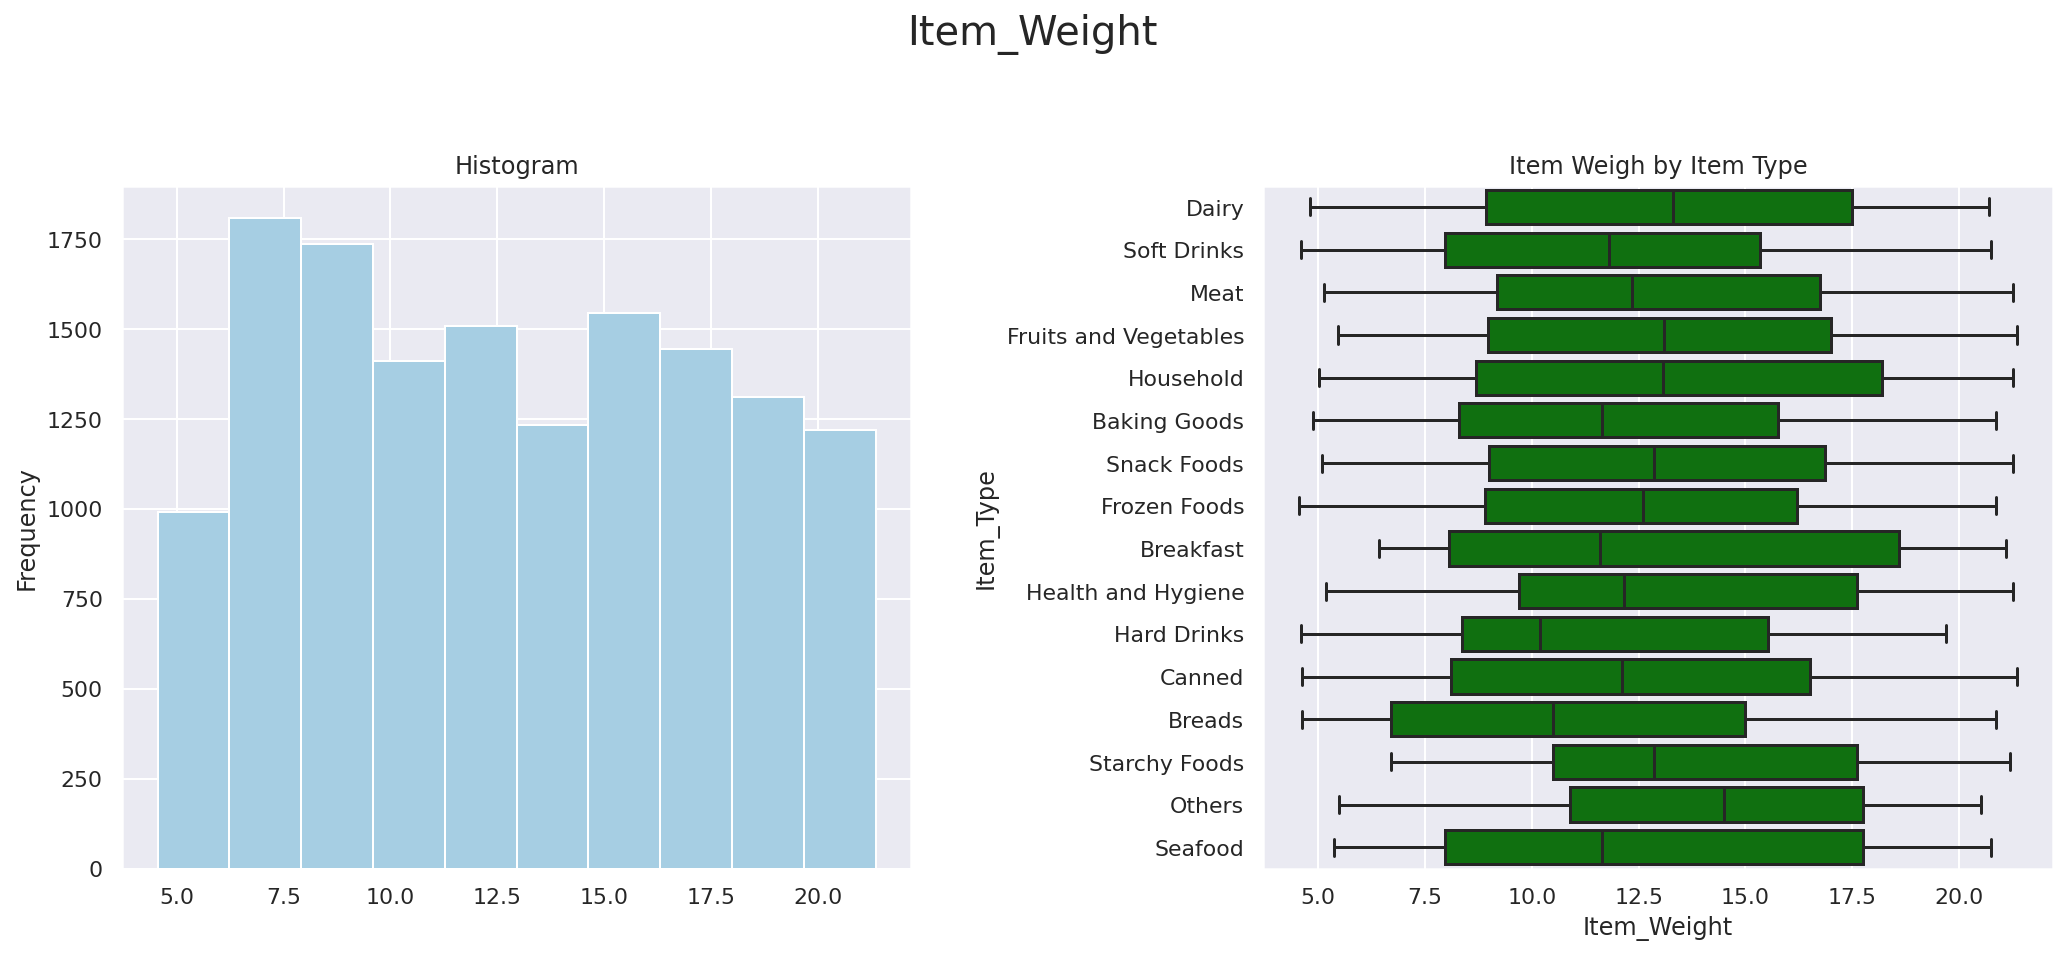

In [9]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,2,1)
df["Item_Weight"].plot.hist()
plt.title("Histogram")
ax2 = fig.add_subplot(1,2,2)
plt.title("Item Weigh by Item Type")
g = sns.boxplot(data=df,y='Item_Type',x='Item_Weight',color='green',ax=ax2)
plt.suptitle("Item_Weight")
plt.tight_layout(pad=3)
plt.show()

In [10]:
df['Item_Weight'] = df.groupby('Item_Type').Item_Weight.apply(lambda x: x.fillna(x.mean()))

#### Item_Visibility & Item_MRP

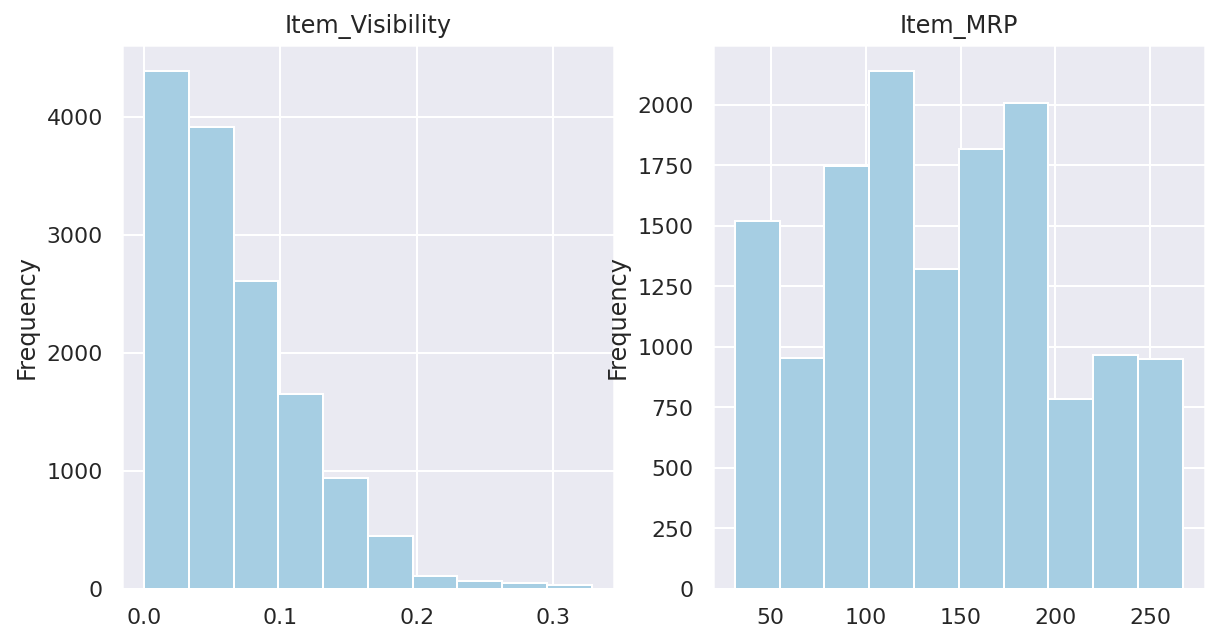

In [11]:
fig = plt.figure(figsize=(15,5))

for n, col in enumerate(["Item_Visibility",	"Item_MRP"]):
  fig.add_subplot(1,3,n+1)
  df[col].plot.hist()
  plt.title(col)

We see that Item_Vibility has a right tail (positive bias), we will remove the positive bias by calculating the square root.

Text(0.5, 1.0, 'SQRT Item_Visibility')

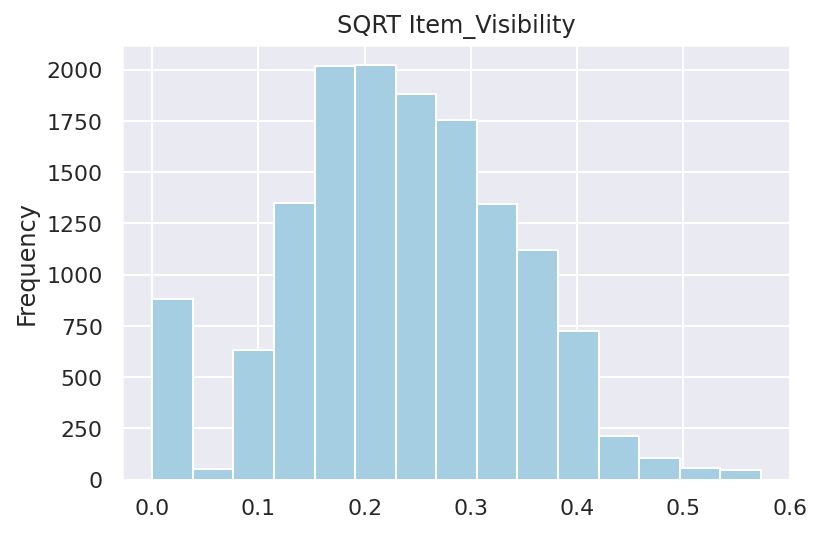

In [12]:
df['Item_Visibility_SQRT'] = df.Item_Visibility.apply(np.sqrt)
df['Item_Visibility_SQRT'].plot.hist(bins=15)
plt.title('SQRT Item_Visibility')

#### Item_Fat_Content.
>We basically have two categories within Item_Fat_Content, Low Fat and Regular.
Here we will unify all the values for each category and create a new column, which will have a value of 1 for regular products and 0 for low-fat products.


In [13]:
df.Item_Fat_Content.unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [14]:
def Item_Fat_encoder(s)->pd.Series:
    s = s.str.upper().apply(lambda x: x.strip())
    return s.str.replace(r"L.*",'0',regex=True)\
            .str.replace(r"R.*",'1',regex=True)\
            .astype(int)
df['Item_Regular_Fat'] = Item_Fat_encoder(df['Item_Fat_Content'])
df.drop('Item_Fat_Content',axis=True,inplace=True)           

## Outlet Features

In [15]:
out_size_null_example = df[list(filter(lambda x: "Outlet" in x, df.columns))].loc[lambda x: x["Outlet_Size"].isnull()].head()
out_size_null_example

,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
id,,,,,,
OUT010-FDX07,OUT010,1998,NaN,Tier 3,Grocery Store,732.380
OUT045-FDH17,OUT045,2002,NaN,Tier 2,Supermarket Type1,"1,076.599"
OUT017-FDU28,OUT017,2007,NaN,Tier 2,Supermarket Type1,"4,710.535"
OUT017-NCD06,OUT017,2007,NaN,Tier 2,Supermarket Type1,838.908
OUT010-FDE51,OUT010,1998,NaN,Tier 3,Grocery Store,178.434


### Outlet_Size
> This is our second and last column with missing values.  
The Outlet_Size is not related to the Item_Identifier; it is related to the physical place. So we need to analyze the columns with the prefix Outlet to be able to find a way to replace those missing values,
for this, we are going to make a chi-squared test to identify any dependency,

#### Chi2 Test

In [16]:
def chi2_test(x,y):
    observed = pd.crosstab(df[x],df[y])
    result = chi2_contingency(observed= observed,correction=True)
    print(f"{x} % {y}\n---------------------\nChi2 value {result[0]:.2f}\nP-value: {result[1]}\nDegree of freedom: {result[2]}\n---------------------\n")

In [17]:

for x in ['Outlet_Type','Outlet_Location_Type','Outlet_Establishment_Year','Outlet_Identifier']:
    chi2_test(x,'Outlet_Size')
    

Outlet_Type % Outlet_Size
---------------------
Chi2 value 6224.41
P-value: 0.0
Degree of freedom: 6
---------------------

Outlet_Location_Type % Outlet_Size
---------------------
Chi2 value 6825.33
P-value: 0.0
Degree of freedom: 4
---------------------

Outlet_Establishment_Year % Outlet_Size
---------------------
Chi2 value 17705.05
P-value: 0.0
Degree of freedom: 10
---------------------

Outlet_Identifier % Outlet_Size
---------------------
Chi2 value 20376.00
P-value: 0.0
Degree of freedom: 12
---------------------



There is not a dependecy between Outlet_size and the others columns.
I droping this column from our model.

In [18]:
df.drop('Outlet_Size',axis=1,inplace=True)

### Outlet_Establishment_Year

This column we going to transform into a age feature

In [19]:
df['Outlet_Establishment_Age'] =  df['Outlet_Establishment_Year'].transform(lambda x: x-x.min())
df.drop('Outlet_Establishment_Year',axis=1,inplace=True)

# Model
## Scaling  Numercial features
We have to hold all numerical values to the same scale.
For this, we must calculate the Z-score, which means calculating its average and its standard deviation for each column.
Then apply the following formula
$$z = \frac{x - \mu}{\sigma}$$


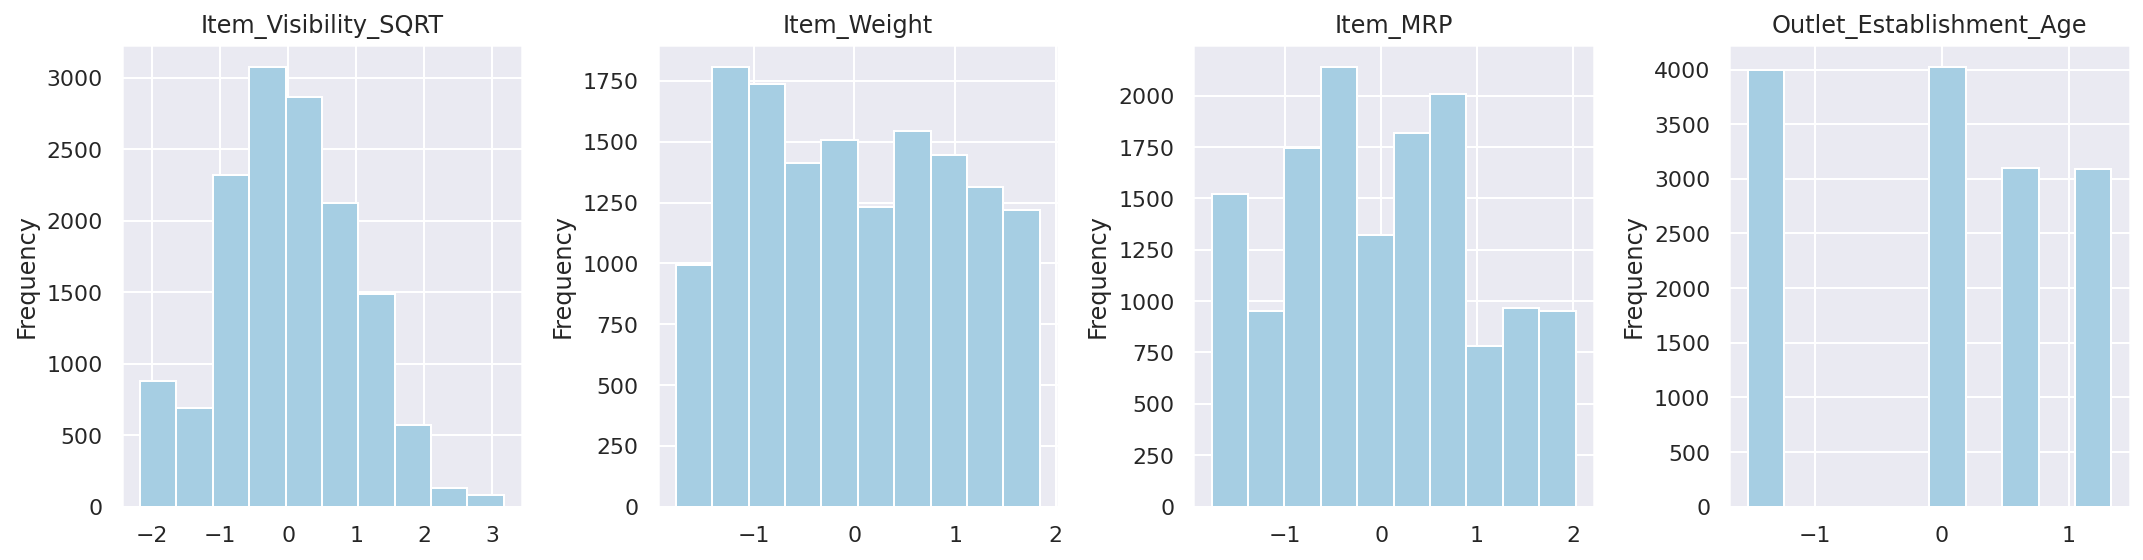

In [20]:
numerical_features = ['Item_Visibility_SQRT','Item_Weight','Item_MRP','Outlet_Establishment_Age']
sc_features =   StandardScaler()
df[numerical_features]  = sc_features.fit_transform(df[numerical_features])
fig = plt.figure(figsize=(15,4))

for n, col in enumerate(numerical_features):
  fig.add_subplot(1,len(numerical_features),n+1)
  df[col].plot.hist()
  plt.title(col)
plt.tight_layout()

## Transfrom Categorical

In [21]:
categorical_features = ['Outlet_Type','Item_Type','Item_Identifier','Outlet_Location_Type','Outlet_Identifier']
features = categorical_features + numerical_features
df = pd.get_dummies(df,columns=categorical_features)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14204 entries, OUT049-FDA15 to OUT045-FDU37
Columns: 1599 entries, Item_Weight to Outlet_Identifier_OUT049
dtypes: float64(6), int64(1), uint8(1592)
memory usage: 22.9+ MB


## Split Train & Test Data

In [22]:
df_train = df.loc[df[target].notnull()].copy()
df_test = df.loc[df[target].isnull()].copy().drop('Item_Outlet_Sales',axis=1)
train_features = df_train.copy().drop('Item_Outlet_Sales',axis=1)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    train_features, df_train[target], test_size=0.1, random_state=13
)
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
reg = GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)
mse = mean_squared_error(y_test,predict  )
r2 = r2_score(y_test, predict )
print("The mean squared error (MSE) on test set: {:.4f}\nr2_score:{:.4f}".format(mse,r2))

The mean squared error (MSE) on test set: 1202959.6113


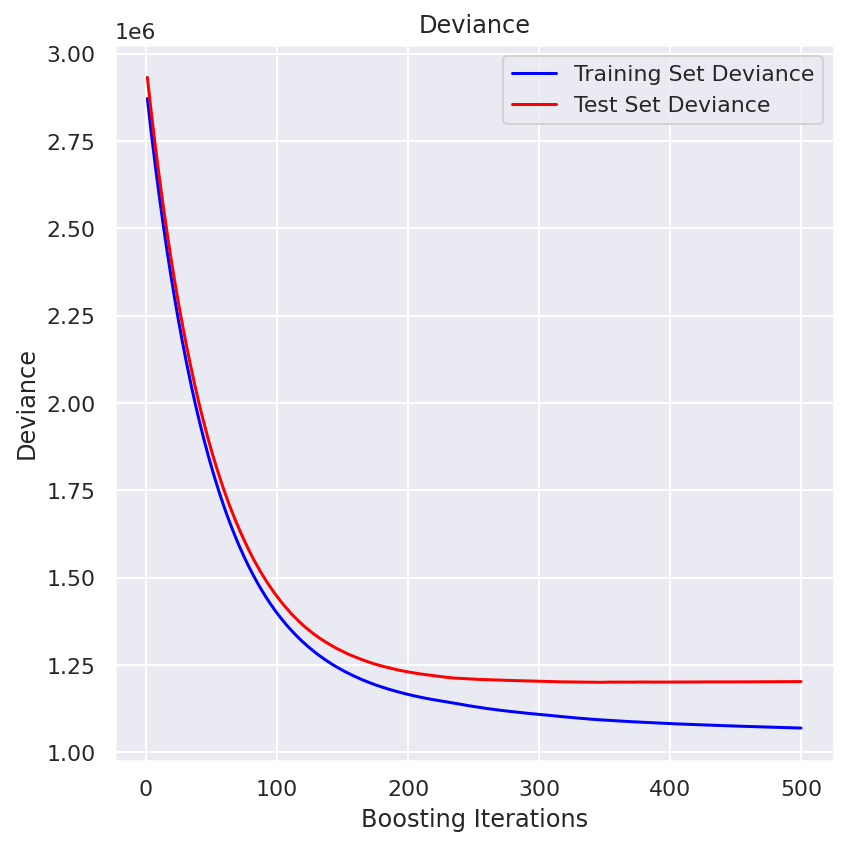

In [24]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

In [107]:
feature_importance = pd.Series(reg.feature_importances_, index = X_train.columns).nlargest(10)
feature_importance.sort_values(ascending=True,inplace=True)


In [60]:
result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

In [ ]:
df_test['Item_Outlet_Sales'] = best_model_rf.predict(df_test)
df_test.reset_index(inplace=True)
id_split =  df_test.id.str.split('-')
df_test['Outlet_Identifier'] = id_split.apply(lambda x:x[1])
df_test['Item_Identifier'] = id_split.apply(lambda x:x[1])
df_test = df_test[['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales']]

In [84]:
len(),columns=X_train.columns[sorted_idx]

1598

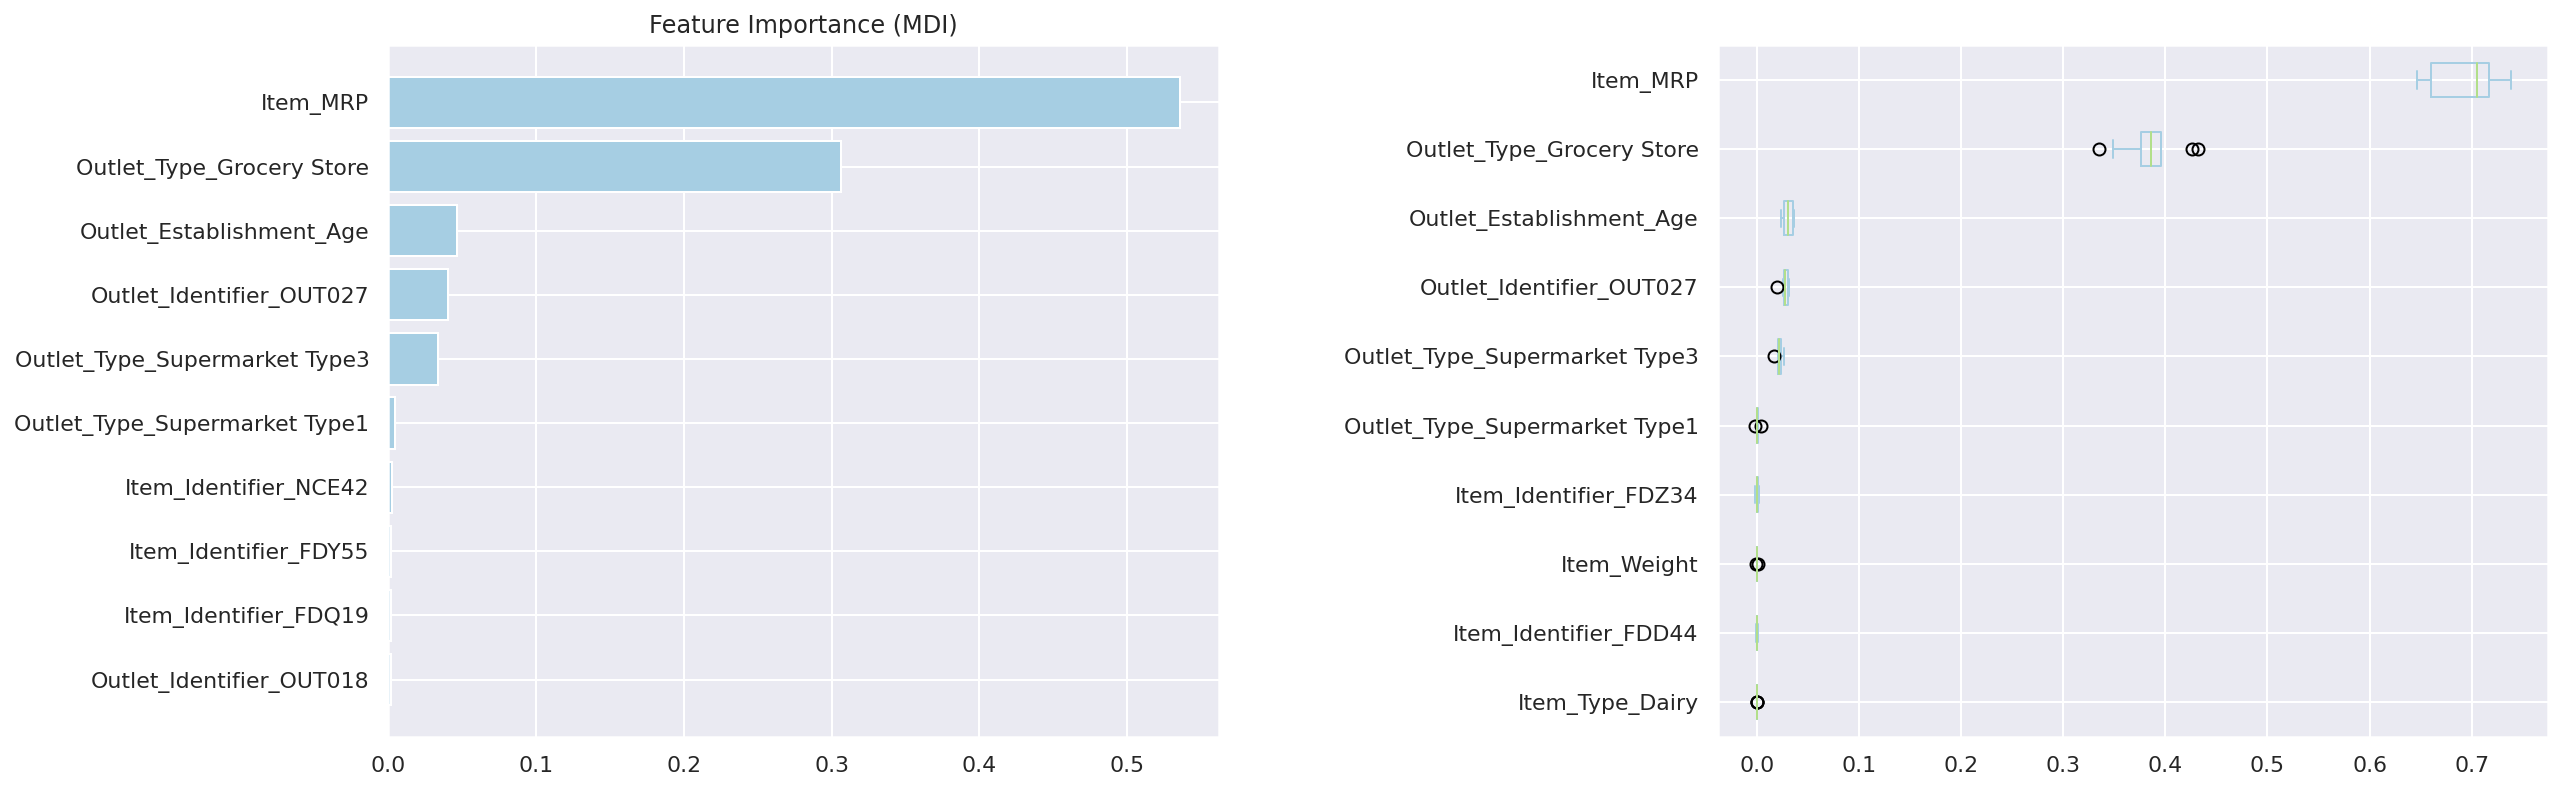

In [108]:
fig = plt.figure(figsize=(15, 6))
ax=plt.subplot(1, 2, 1)
ax.barh(feature_importance.index, feature_importance.values, align="center")
plt.title("Feature Importance (MDI)")
ax2=plt.subplot(1, 2, 2)
pd.DataFrame(data=result.importances[sorted_idx].T,columns=X_train.columns[sorted_idx]).iloc[:,-10:].plot.box(vert=False,ax=ax2)
plt.subplots_adjust(left=0.0,
                    bottom=0.1, 
                    right=1, 
                    top=0.9, 
                    wspace=0.6, 
                    hspace=0.4)
plt.show()

In [111]:
feature_importance.index[-10:]

Index(['Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type3',
       'Outlet_Identifier_OUT027', 'Outlet_Establishment_Age',
       'Outlet_Type_Grocery Store', 'Item_MRP'],
      dtype='object')

In [119]:
clean_features = ['Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type3',
        'Outlet_Establishment_Age',
       'Outlet_Type_Grocery Store', 'Item_MRP','Item_Weight','Item_Type_Dairy']
rf = RandomForestRegressor(max_depth=25,n_estimators=300, n_jobs=-1, random_state=42)
train_x, test_x, train_y, test_y = train_test_split(df_train[clean_features], df_train[target],test_size=0.3) 
# Entrenar modelo
rf.fit(train_x, train_y)

# Predecir valores
predict_train = rf.predict(test_x)
print(f'RMSE on test data: {mean_squared_error(test_y, predict_train):.2f}\nr2_score: {r2_score(test_y, predict_train):.2f}', )

RMSE on test data: 1349083.55
r2_score: 0.55


In [126]:

params_grid = {
    "n_estimators": np.arange(50,500,50),
    "max_depth": [1,2,3],
    "min_samples_split": [2,3,4],
    "learning_rate": np.arange(0.01,0.1,0.005),
    "loss": ['squared_error', 'absolute_error', 'quantile'],
}
gbr = GradientBoostingRegressor()
grid_search = GridSearchCV(estimator=gbr, cv=5, param_grid=params_grid, 
    n_jobs=-1)
grid_search.fit(df_train[clean_features], df_train[target])
grid_search.best_params_

KeyboardInterrupt: 